# Simulations with PyHEADTAIL

# Transversal motion of the beam

## Imports

In [1]:
import PyHEADTAIL

PyHEADTAIL v1.12.4




In [2]:
from PyHEADTAIL.trackers.wrapper import LongWrapper
from PyHEADTAIL.trackers.transverse_tracking import TransverseSegmentMap

In [3]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib tk

import matplotlib.image as mpimg

from scipy.constants import c, e, m_p

from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
from PyCERNmachines.CERNmachines import PS

## Defining several parameters of the accelerator

In [5]:
Ekin = 1.4e9
gamma = 1 + Ekin * e /(m_p*c**2)
beta = np.sqrt(1-gamma**-2)

Q_x = 6.23
Q_y = 6.24

# The number of segments is defined here.
machine = PS(n_segments=100, gamma=gamma, machine_configuration = 'LHCbeam_h7',
            longitudinal_focusing = 'non-linear', Q_x=Q_x, Q_y=Q_y)

Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_y = 6.24
Synchrotron init. From kwargs: n_segments = 100
Synchrotron init. From kwargs: gamma = 2.4921045053287254
Synchrotron init. From kwargs: Q_x = 6.23


In [6]:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

## Defining several parameters for the bunch/simulation

Defining the count of turns

In [7]:
n_turns = 12#128

Defining other parameters

In [55]:
n_macroparticles = 1000
intensity = 1.6e12
epsn_x = epsn_y = 2.5e-6
sigma_z = 185e-9/4*beta*c

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, epsn_x=epsn_x,
    epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562553m.
... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169357977446
--> Emittance: 1.2136287277619604


In [9]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

In [10]:
rfsystems._elements.append(
    LongWrapper(machine.circumference))

Defining arrays to save the values of the simulation

In [11]:
x_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
z_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
dp_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)

## Simulation calculations

In [12]:
j = 0

for i in range(n_turns):
    for m in machine.one_turn_map:
        if isinstance(m, TransverseSegmentMap):
            x_rec[j, :] = bunch.x
            y_rec[j, :] = bunch.y
            z_rec[j, :] = bunch.z
            dp_rec[j, :] = bunch.dp
            j += 1
        m.track(bunch)

### Animating the video of the transversal motion

In [21]:
!mkdir Video_Transversal_Motion

mkdir: cannot create directory `Video_Transversal_Motion': File exists


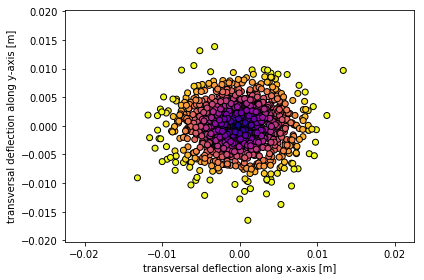

In [22]:
!rm Video_Transversal_Motion/*

zz = np.linspace(rfbucket.z_left - 3 * np.diff(rfbucket.interval), 
                 rfbucket.z_right + 3 * np.diff(rfbucket.interval), 
                 num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.4, dp_max*1.4, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

def animate (i):
    plt.cla()
    x = x_rec[i, :]
    y = y_rec[i, :]
    
    plt.scatter(x, y, marker='o', c=np.sqrt(x**2+y**2), edgecolor='black',
                cmap=plt.get_cmap('plasma'), vmax=0.01)

    plt.xlim(x_rec.min()*1.2, x_rec.max()*1.2)
    plt.ylim(y_rec.min()*1.2, y_rec.max()*1.2)
    
    plt.xlabel('transversal deflection along x-axis [m]')
    plt.ylabel('transversal deflection along y-axis [m]')
    
    # This is the mean (or the centroid) of the bunch.
    #plt.scatter(mx, my, marker='o', c='red')
    
    plt.tight_layout()
    
    plt.savefig("Video_Transversal_Motion/src{:05d}.png".format(i), dpi=200, bbox_inches='tight')

for i in range(0, len(x_rec), 1):
    animate(i)

In [23]:
!cd Video_Transversal_Motion; ffmpeg -y -pattern_type glob -i "*.png" -c:v msmpeg4v2 -q:v 3 -pix_fmt yuv420p Transversal_Motion.wmv

ffmpeg version N-90661-g52623bc Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-18)
  configuration: --prefix=/afs/cern.ch/user/p/papostel/lib/
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 14.100 /  7. 14.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
Input #0, image2, from '*.png':
  Duration: 00:00:48.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1174x777 [SAR 7874:7874 DAR 1174:777], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> msmpeg4v2 (native))
Press [q] to stop, [?] for help
Output #0, asf, to 'Transversal_Motion.wmv':
  Metadata:
    WM/EncodingSettings: Lavf58.11.101
    Stream #0:0: Video: msmpeg4v2 (MP42 / 0x3234504D), yuv420p, 1174x777 [SAR 1:1 DAR 1174:777], q=2-31, 200 kb/s, 25 f

    Last message repeated 729 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.21x    
    Last message repeated 708 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.21x    
    Last message repeated 248 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.11x    
    Last message repeated 668 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 421 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.13x    
    Last message repeated 1126 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.15x    
    Last message repeated 1065 times
[msmpeg4v2 @ 0x27e8340] warning, clipping 1 dct coefficients to -127..127eed=1.18x    
    Last message repeated 562 times
[msmpeg4v2 @ 0x27e8340] warning, clippin

### Plotting a histogram of the intensity distribution

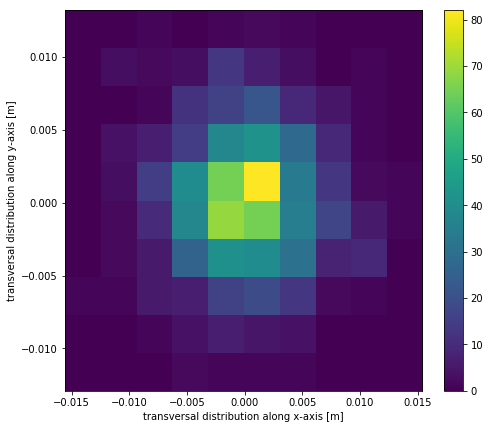

In [56]:
plt.figure(figsize=(8,7))
plt.hist2d(bunch.x, bunch.y, bins=10);

# Or with hexagons.
#plt.hexbin(bunch.x, bunch.y);

plt.colorbar()

plt.xlabel('transversal distribution along x-axis [m]')
plt.ylabel('transversal distribution along y-axis [m]')

plt.savefig("Histogram.png".format(i), dpi=600)

### Plotting a Gaussian-like distribution along one axis

Along the x-axis

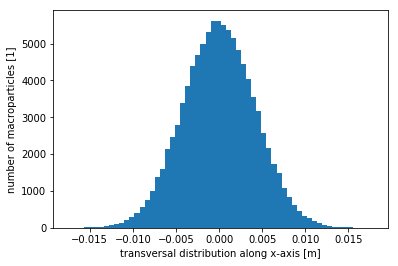

In [45]:
plt.hist(bunch.x, bins=60)

plt.xlabel('transversal distribution along x-axis [m]')
plt.ylabel('number of macroparticles [1]')
    
plt.savefig("Gaussian_x-axis.png".format(i), dpi=600)

Along the y-axis

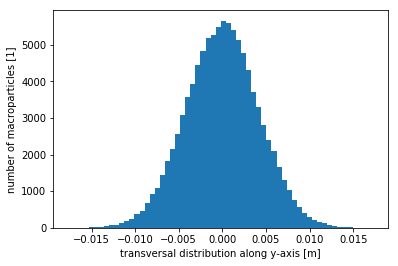

In [46]:
plt.hist(bunch.y, bins=60)

plt.xlabel('transversal distribution along y-axis [m]')
plt.ylabel('number of macroparticles [1]')
    
plt.savefig("Gaussian_y-axis.png".format(i), dpi=600)

## The End